In [1]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import re
import string
from string import punctuation
import nltk
from nltk.corpus import stopwords

In [2]:
nltk.download("stopwords")
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout
from tensorflow.keras.callbacks import EarlyStopping

df = pd.read_csv("playdata/train.csv")

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Boe\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [4]:
df.head()

,id,label,tweet
0,1,0,#fingerprint #Pregnancy Test https://goo.gl/h1...
1,2,0,Finally a transparant silicon case ^^ Thanks t...
2,3,0,We love this! Would you go? #talk #makememorie...
3,4,0,I'm wired I know I'm George I was made that wa...
4,5,1,What amazing service! Apple won't even talk to...


In [5]:
df = df.drop(['id'],axis=1)
df.dropna(inplace=True)

In [6]:
df.head()

,label,tweet
0,0,#fingerprint #Pregnancy Test https://goo.gl/h1...
1,0,Finally a transparant silicon case ^^ Thanks t...
2,0,We love this! Would you go? #talk #makememorie...
3,0,I'm wired I know I'm George I was made that wa...
4,1,What amazing service! Apple won't even talk to...


In [7]:
df['polarity_rating'] = df['label'].apply(lambda x: 'Positive' if x == 0 else 'Negative')

In [8]:
df.head()

,label,tweet,polarity_rating
0,0,#fingerprint #Pregnancy Test https://goo.gl/h1...,Positive
1,0,Finally a transparant silicon case ^^ Thanks t...,Positive
2,0,We love this! Would you go? #talk #makememorie...,Positive
3,0,I'm wired I know I'm George I was made that wa...,Positive
4,1,What amazing service! Apple won't even talk to...,Negative


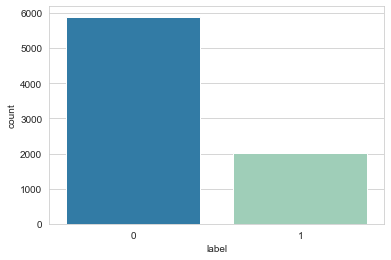

In [9]:
sns.set_style('whitegrid')
sns.countplot(x='label',data=df, palette='YlGnBu_r')
#plt.show()

# data processing
df_pos = df[df['polarity_rating'] == 'Positive'][0:5000]
df_neg = df[df['polarity_rating'] == 'Negative']

#sample negative and and create final dataset

df_Neg_over = df_neg.sample(5000,replace=True)
df = pd.concat([df_pos,df_Neg_over],axis=0)

In [10]:
def get_text_processing(text):
    stpword = stopwords.words('english')
    no_punctuation = [char for char in text if char not in string.punctuation]
    no_punctuation = ''.join(no_punctuation)
    return ' '.join([word for word in no_punctuation.split() if word.lower() not in stpword])


df['cl_tweet'] = df['tweet'].apply(get_text_processing)

In [11]:
df.head()

,label,tweet,polarity_rating,cl_tweet
0,0,#fingerprint #Pregnancy Test https://goo.gl/h1...,Positive,fingerprint Pregnancy Test httpsgooglh1MfQV an...
1,0,Finally a transparant silicon case ^^ Thanks t...,Positive,Finally transparant silicon case Thanks uncle ...
2,0,We love this! Would you go? #talk #makememorie...,Positive,love Would go talk makememories unplug relax i...
3,0,I'm wired I know I'm George I was made that wa...,Positive,Im wired know Im George made way iphone cute d...
6,0,Happy for us .. #instapic #instadaily #us #son...,Positive,Happy us instapic instadaily us sony xperia xp...


In [12]:
df = df[['cl_tweet', 'polarity_rating']]
one_hot = pd.get_dummies(df['polarity_rating'])
df.drop(['polarity_rating'],axis=1, inplace=True)
df = pd.concat([df,one_hot],axis=1)

In [13]:
df.head()

,cl_tweet,Negative,Positive
0,fingerprint Pregnancy Test httpsgooglh1MfQV an...,0,1
1,Finally transparant silicon case Thanks uncle ...,0,1
2,love Would go talk makememories unplug relax i...,0,1
3,Im wired know Im George made way iphone cute d...,0,1
6,Happy us instapic instadaily us sony xperia xp...,0,1


In [14]:
X = df['cl_tweet'].values
Y = df.drop("cl_tweet", axis=1).values
X_train, X_test, Y_train, Y_test = train_test_split(X,Y,test_size=0.30, random_state=42)

In [15]:
vect = CountVectorizer()
X_train = vect.fit_transform(X_train)
X_test = vect.transform(X_test)

In [16]:
tfidf = TfidfTransformer()
X_train = tfidf.fit_transform(X_train)
X_test = tfidf.transform(X_test)
X_train = X_train.toarray()
X_test = X_test.toarray()

In [23]:
model = Sequential()
model.add(Dense(units=12673, activation="relu"))
model.add(Dropout(0.5))
model.add(Dense(units=2500, activation="relu"))
model.add(Dropout(0.5))
model.add(Dense(units=350, activation="relu"))
model.add(Dropout(0.5))
model.add(Dense(units=3, activation="softmax"))
opt = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(loss="categorical_crossentropy", optimizer='adam', metrics=["accuracy"])
early_stop = EarlyStopping(monitor="val_loss", mode="min", verbose=1, patience=2)

In [25]:
model.fit(
    x=X_train,
    y=Y_train,
    batch_size=256,
    epochs=100,
    validation_data=(X_test, Y_test),
    verbose=1,
    callbacks=early_stop,
)

Epoch 1/100


TypeError: 'NoneType' object is not callable